<a href="https://colab.research.google.com/github/khlodMohamed/Computer-Vision/blob/main/Image%20segmentation/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Imports

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision

!pip install albumentations==0.4.6
import albumentations 

import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
from google.colab import drive

import torch
import torch.nn as nn
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader


##Prep

In [ ]:
# connecting to drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
os.mkdir('/content/zip') 
%cd /content/zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Validation_Part1_GroundTruth.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Test_v2_Part1_GroundTruth.zip

In [ ]:
os.mkdir('/content/unzip') 
%cd /content/unzip
print(os.getcwd())
!unzip /content/zip/ISIC-2017_Training_Data.zip
!unzip /content/zip/ISIC-2017_Training_Part1_GroundTruth.zip
!unzip /content/zip/ISIC-2017_Validation_Data.zip
!unzip /content/zip/ISIC-2017_Validation_Part1_GroundTruth.zip
!unzip /content/zip/ISIC-2017_Test_v2_Data.zip
!unzip /content/zip/ISIC-2017_Test_v2_Part1_GroundTruth.zip

In [ ]:
%cd /content/unzip/ISIC-2017_Training_Data
!rm ISIC-2017_Training_Data_metadata.csv
!rm *.png
%cd /content/unzip/ISIC-2017_Validation_Data
!rm ISIC-2017_Validation_Data_metadata.csv
!rm *.png
%cd /content/unzip/ISIC-2017_Test_v2_Data
!rm ISIC-2017_Test_v2_Data_metadata.csv
!rm *.png
%cd /content

/content/unzip/ISIC-2017_Training_Data
/content/unzip/ISIC-2017_Validation_Data
/content/unzip/ISIC-2017_Test_v2_Data
/content


In [ ]:
#remove .ipynb_checkpoints
%cd /content/unzip/ISIC-2017_Training_Data
%rm -rf `find -type d -name .ipynb_checkpoints`
%cd /content/unzip/ISIC-2017_Validation_Data
%rm -rf `find -type d -name .ipynb_checkpoints`
%cd /content

/content/unzip/ISIC-2017_Training_Data
/content/unzip/ISIC-2017_Validation_Data
/content


In [ ]:

val_ = os.listdir('/content/unzip/ISIC-2017_Validation_Data')
val_m = os.listdir('/content/unzip/ISIC-2017_Validation_Part1_GroundTruth')
train_ = os.listdir('/content/unzip/ISIC-2017_Training_Data')
train_m = os.listdir('/content/unzip/ISIC-2017_Training_Part1_GroundTruth')
test_ = os.listdir('/content/unzip/ISIC-2017_Test_v2_Data')
test_m = os.listdir('/content/unzip/ISIC-2017_Test_v2_Part1_GroundTruth')
print(len(train_))
print(len(train_m))
print(len(val_))
print(len(val_m))
print(len(test_))
print(len(test_m))

2000
2000
150
150
600
600


##Functions

In [ ]:
import os, shutil
def delete(folder_path):
  for filename in os.listdir(folder_path):
      file_path = os.path.join(folder_path, filename)
      try:
          if os.path.isfile(file_path) or os.path.islink(file_path):
              os.unlink(file_path)
          elif os.path.isdir(file_path):
              shutil.rmtree(file_path)
      except Exception as e:
          print('Failed to delete %s. Reason: %s' % (file_path, e))
def show_img(folder_path, i):
  temp = os.listdir(folder_path)
  img_path = os.path.join(folder_path, temp[i])
  img = cv2.imread(img_path)
  print(img.shape)
  cv2_imshow(img)


##Dataset

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class ISICDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = os.listdir(image_dir)
        # self.images = self.images[0:20]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.images[index])
        mask_path = os.path.join(self.mask_dir, self.images[index].replace(".jpg", "_segmentation.png"))
        image = np.array(Image.open(img_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("L"), dtype=np.float32)



        mask[mask == 255.0] = 1.0

        if self.transform is not None:
            augmentations = self.transform(image=image, mask=mask)
            image = augmentations["image"]
            mask = augmentations["mask"]

        return image, mask


##Utili


In [ ]:

from torch.utils.data import DataLoader
%cd /content
def save_checkpoint(state, filename="/content/drive/MyDrive/Colab Notebooks/Computer Vision/my_checkpoint2.pth.tar"):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])


def get_loaders(
    train_dir,
    train_maskdir,
    val_dir,
    val_maskdir,
    test_dir,
    test_maskdir,
    batch_size_train,
    batch_size_val,
    batch_size_test,
    train_transform,
    val_transform,
    num_workers=4,
    pin_memory=True,
):
    train_ds = ISICDataset(
        image_dir=train_dir,
        mask_dir=train_maskdir,
        transform=train_transform,
    )

    train_loader = DataLoader(
        train_ds,
        batch_size=batch_size_train,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=True,
    )

    val_ds = ISICDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    val_loader = DataLoader(
        val_ds,
        batch_size=batch_size_val,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    test_ds = ISICDataset(
        image_dir=val_dir,
        mask_dir=val_maskdir,
        transform=val_transform,
    )

    test_loader = DataLoader(
        val_ds,
        batch_size=batch_size_test,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False,
    )
    return train_loader, val_loader, test_loader


/content


##Model

In [ ]:


class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d( 
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

def test():
    x = torch.randn((3, 1, 161, 161))
    model = UNET(in_channels=1, out_channels=1)
    preds = model(x)
    assert preds.shape == x.shape

if __name__ == "__main__":
    test()

##Loss

In [ ]:

def loss_fn(inputs, targets, smooth=0.5):

    #comment out if your model contains a sigmoid or equivalent activation layer
    inputs = torch.sigmoid(inputs)    
    inputs.data = (inputs.data > 0.5 ).float()
    inputs = inputs.view(-1)
    targets = targets.view(-1)
    #flatten label and prediction tensors

    
    #intersection is equivalent to True Positive count
    #union is the mutually inclusive area of all labels & predictions 
    intersection = (inputs * targets).sum()
    total = (inputs + targets).sum()
    union = total - intersection 
    
    IoU = (intersection + smooth)/(union + smooth)
    return 1 - IoU

##Transformations

In [ ]:
def get_transformations():
  train_transform = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Rotate(limit=35, p=0.75),
          # A.HorizontalFlip(p=0.5),
          A.HorizontalFlip(p=0.75),
          A.VerticalFlip(p=0.75),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          
          ToTensorV2(),
      ],
  )

  val_transforms = A.Compose(
      [
          A.Resize(height=IMAGE_HEIGHT, width=IMAGE_WIDTH),
          A.Normalize(
              mean=[0.0, 0.0, 0.0],
              std=[1.0, 1.0, 1.0],
              max_pixel_value=255.0,
          ),
          ToTensorV2(),
      ],
  )

  return train_transform, val_transforms

##Train

In [ ]:
def train_fn(loader, model, optimizer, loss_fn, scaler):
    losses = []
    avg_loss = 0
    loop = tqdm(loader, total=len(loader))
    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.float().unsqueeze(1).to(device=DEVICE)

        # forward
        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)
            losses.append(loss)
            avg_loss = sum(losses)/len(losses)


        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_description(f"Train")
        loop.set_postfix(loss = avg_loss.cpu().detach().numpy())


    

def val_fn(loader, model, loss_fn):
    loop = tqdm(loader, total=len(loader))
    avg_loss = 0
    losses = []
    model.eval()
    with torch.no_grad():
      for batch_idx, (data, targets) in enumerate(loop):
          data = data.to(device=DEVICE)
          targets = targets.float().unsqueeze(1).to(device=DEVICE)
          predictions = model(data)
          loss = loss_fn(predictions, targets)
          losses.append(loss)
          avg_loss = sum(losses)/len(losses)
          loop.set_description(f"Val")
          loop.set_postfix(loss = avg_loss.cpu().numpy())

    model.train()
    return avg_loss
 
def test_fn(loader, model, loss_fn, folder):
  loop = tqdm(loader, total=len(loader))
  losses = []
  avg_loss = 0
  model.eval()
  for batch_idx, (data, targets) in enumerate(loop):
    data = data.to(device=DEVICE)
    with torch.no_grad():
      targets = targets.float().unsqueeze(1).to(device=DEVICE)
      predictions = model(data)
      loss = loss_fn(predictions, targets)
      losses.append(loss)
    avg_loss = sum(losses)/len(losses)
    loop.set_description(f"Test")
    loop.set_postfix(loss = avg_loss.cpu().numpy())

    torchvision.utils.save_image(
            predictions, f"{folder}/pred_{batch_idx}.png"
        )
    torchvision.utils.save_image(targets, f"{folder}/mask_{batch_idx}.png")
    torchvision.utils.save_image(data, f"{folder}/ori_{batch_idx}.png")
  model.train()
  return avg_loss, losses
    

##Main

In [ ]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

for i in range(10):
  torch.cuda.empty_cache()
  import gc
  gc.collect()

# Hyperparameters etc.
LEARNING_RATE = 1e-5
# 1e-4 --> overfitss "Train loss decrease while the val loss increase"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
BATCH_SIZE_TRAIN = 4
BATCH_SIZE_VAL = 1
BATCH_SIZE_TEST = 1
NUM_EPOCHS = 50
NUM_WORKERS = 1
IMAGE_HEIGHT = 680 # 1280 originally
IMAGE_WIDTH = 680  # 1918 originally
PIN_MEMORY = True
LOAD_MODEL = True
import tensorflow as tf
TRAIN_IMG_DIR = "/content/unzip/ISIC-2017_Training_Data/"
TRAIN_MASK_DIR = "/content/unzip/ISIC-2017_Training_Part1_GroundTruth/"
VAL_IMG_DIR = "/content/unzip/ISIC-2017_Validation_Data/"
VAL_MASK_DIR = "/content/unzip/ISIC-2017_Validation_Part1_GroundTruth/"
TEST_IMG_DIR = "/content/unzip/ISIC-2017_Test_v2_Data"
TEST_MASK_DIR = "/content/unzip/ISIC-2017_Test_v2_Part1_GroundTruth"

train_transform, val_transforms = get_transformations()

train_loader, val_loader, test_loader = get_loaders(
    TRAIN_IMG_DIR,
    TRAIN_MASK_DIR,
    VAL_IMG_DIR,
    VAL_MASK_DIR,
    TEST_IMG_DIR,
    TEST_MASK_DIR,
    BATCH_SIZE_TRAIN,
    BATCH_SIZE_VAL,
    BATCH_SIZE_TEST,
    train_transform,
    val_transforms,        
    PIN_MEMORY,
)



In [ ]:






def main():
    loss_tracker = 1

    model = UNET(in_channels=3, out_channels=1).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    # optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)


    if LOAD_MODEL:
       load_checkpoint(torch.load("/content/drive/MyDrive/Colab Notebooks/Computer Vision/my_checkpoint2.pth.tar"), model)
       loss_tracker = val_fn(val_loader, model, loss_fn)
       loss_tracker = loss_tracker.cpu().numpy()
       print(loss_tracker)
    scaler = torch.cuda.amp.GradScaler()
    # print(sum(i > 0.5 for i in scores))
    for epoch in range(NUM_EPOCHS):

    #   # print(sum(scores.data) / len(scores.data))
      
      train_fn(train_loader, model, optimizer,loss_fn, scaler)

      avg_loss = val_fn(val_loader, model, loss_fn)
      avg_loss = avg_loss.cpu().numpy()
      print(avg_loss)
      if (avg_loss < loss_tracker): 
        loss_tracker = avg_loss       
        checkpoint = {
            "state_dict": model.state_dict(),
            "optimizer":optimizer.state_dict(),
        }
        save_checkpoint(checkpoint)





if __name__ == "__main__":
    main()

    

In [ ]:
def test(model, checkpoint):  
  load_checkpoint(torch.load(checkpoint), model)
  scores, losses = test_fn(test_loader, model, loss_fn, "/content/saved_images")
  return scores, losses

In [ ]:
model = UNET(in_channels=3, out_channels=1).to(DEVICE)
checkpoint = "/content/drive/MyDrive/Colab Notebooks/Computer Vision/my_checkpoint2.pth.tar"
scores, losses = test(model, checkpoint)

print(f"\nAverage IOU loss: {scores}")
j2 = [i for i in losses if i < 0.5]
print(f"{round((len(j2)/len(losses))*100,2)} % of the test images with loss less than 0.5")

=> Loading checkpoint


Test: 100%|██████████| 150/150 [01:03<00:00,  2.37it/s, loss=0.3036067]


Average IOU loss: 0.30360668897628784
79.33 % of the test images with loss less than 0.5


tensor(0.3598, device='cuda:0')


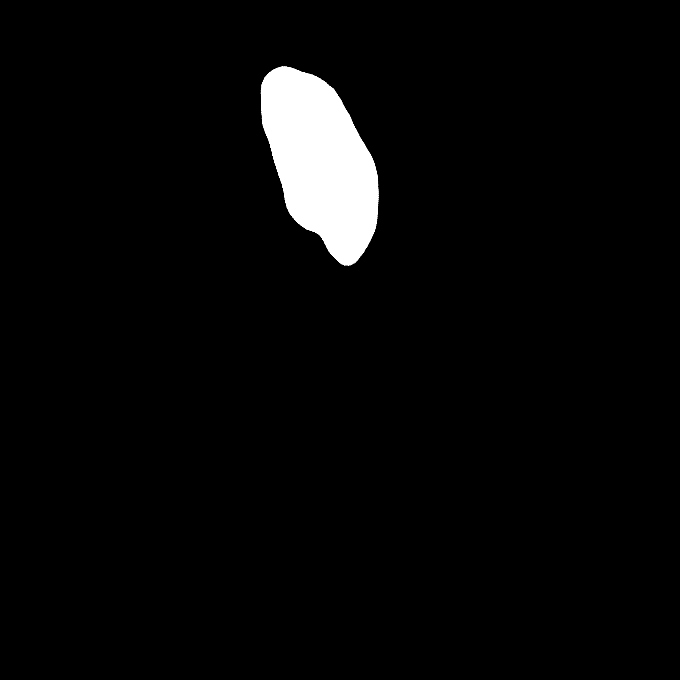

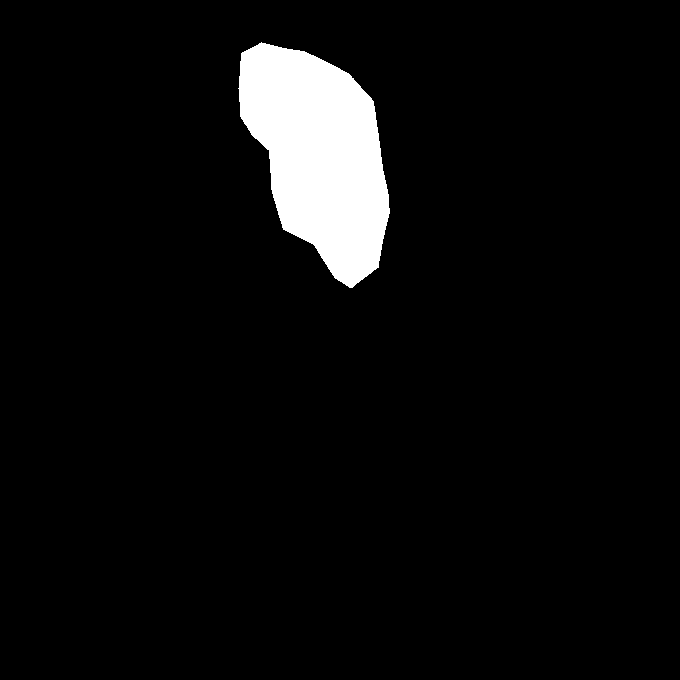

In [ ]:
# min_value = max(losses)
# min_value = losses == 0.4167
min_value = [i for i in losses if i < 0.5]
# min_value = losses[25]
index = 10
min_index = losses.index(min_value[index])
# min_index = losses.index(min_value)
img_path_pred = "/content/saved_images/pred_"+str(min_index)+".png"
img_path_org = "/content/saved_images/mask_"+str(min_index)+".png"
img_pred = cv2.imread(img_path_pred)
img_org = cv2.imread(img_path_org)



print(min_value[index])
cv2_imshow(img_pred)
cv2_imshow(img_org)
